The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.4


# RMSProp
:label:`sec_rmsprop`

One of the key issues in :numref:`sec_adagrad` is that the learning rate decreases at a predefined schedule of effectively $\mathcal{O}(t^{-\frac{1}{2}})$. While this is generally appropriate for convex problems, it might not be ideal for nonconvex ones, such as those encountered in deep learning. Yet, the coordinate-wise adaptivity of Adagrad is highly desirable as a preconditioner.

:cite:`Tieleman.Hinton.2012` proposed the RMSProp algorithm as a simple fix to decouple rate scheduling from coordinate-adaptive learning rates. The issue is that Adagrad accumulates the squares of the gradient $\mathbf{g}_t$ into a state vector $\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$. As a result $\mathbf{s}_t$ keeps on growing without bound due to the lack of normalization, essentially linearly as the algorithm converges.

One way of fixing this problem would be to use $\mathbf{s}_t / t$. For reasonable distributions of $\mathbf{g}_t$ this will converge. Unfortunately it might take a very long time until the limit behavior starts to matter since the procedure remembers the full trajectory of values. An alternative is to use a leaky average in the same way we used in the momentum method, i.e., $\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$ for some parameter $\gamma > 0$. Keeping all other parts unchanged yields RMSProp.

## The Algorithm

Let us write out the equations in detail.

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. Given this expansion we are now free to control the learning rate $\eta$ independently of the scaling that is applied on a per-coordinate basis. In terms of leaky averages we can apply the same reasoning as previously applied in the case of the momentum method. Expanding the definition of $\mathbf{s}_t$ yields

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

As before in :numref:`sec_momentum` we use $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$. Hence the sum of weights is normalized to $1$ with a half-life time of an observation of $\gamma^{-1}$. Let us visualize the weights for the past 40 time steps for various choices of $\gamma$.


In [1]:
from d2l import tensorflow as d2l
import tensorflow as tf
import math

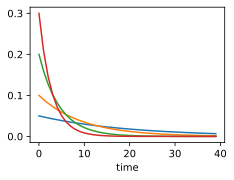

In [2]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = d2l.numpy(tf.range(40))
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

## Implementation from Scratch

As before we use the quadratic function $f(\mathbf{x})=0.1x_1^2+2x_2^2$ to observe the trajectory of RMSProp. Recall that in :numref:`sec_adagrad`, when we used Adagrad with a learning rate of 0.4, the variables moved only very slowly in the later stages of the algorithm since the learning rate decreased too quickly. Since $\eta$ is controlled separately this does not happen with RMSProp.


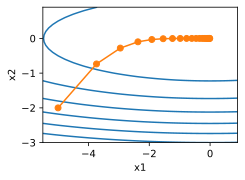

In [3]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

Next, we implement RMSProp to be used in a deep network. This is equally straightforward.


In [4]:
def init_rmsprop_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return (s_w, s_b)

In [5]:
def rmsprop(params, grads, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s, g in zip(params, states, grads):
        s[:].assign(gamma * s + (1 - gamma) * tf.math.square(g))
        p[:].assign(p - hyperparams['lr'] * g / tf.math.sqrt(s + eps))

We set the initial learning rate to 0.01 and the weighting term $\gamma$ to 0.9. That is, $\mathbf{s}$ aggregates on average over the past $1/(1-\gamma) = 10$ observations of the square gradient.


loss: 0.242, 0.123 sec/epoch


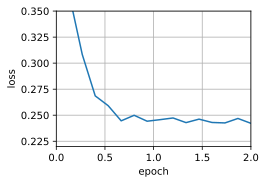

In [6]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## Concise Implementation

Since RMSProp is a rather popular algorithm it is also available in the `Trainer` instance. All we need to do is instantiate it using an algorithm named `rmsprop`, assigning $\gamma$ to the parameter `gamma1`.


loss: 0.246, 0.125 sec/epoch


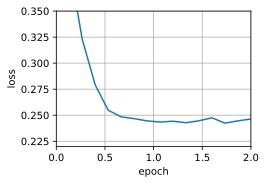

In [7]:
trainer = tf.keras.optimizers.RMSprop
d2l.train_concise_ch11(trainer, {'learning_rate': 0.01, 'rho': 0.9},
                       data_iter)

## Summary

* RMSProp is very similar to Adagrad insofar as both use the square of the gradient to scale coefficients.
* RMSProp shares with momentum the leaky averaging. However, RMSProp uses the technique to adjust the coefficient-wise preconditioner.
* The learning rate needs to be scheduled by the experimenter in practice.
* The coefficient $\gamma$ determines how long the history is when adjusting the per-coordinate scale.

## Exercises

1. What happens experimentally if we set $\gamma = 1$? Why?
1. Rotate the optimization problem to minimize $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. What happens to the convergence?
1. Try out what happens to RMSProp on a real machine learning problem, such as training on Fashion-MNIST. Experiment with different choices for adjusting the learning rate.
1. Would you want to adjust $\gamma$ as optimization progresses? How sensitive is RMSProp to this?


[Discussions](https://discuss.d2l.ai/t/1075)
